<a href="https://colab.research.google.com/github/craycrayfish/adv-atk-neu/blob/master/First_Attack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## BSc Project: Adversarial Attacks on CNN Model

The First Attack - Single Pixel Attack

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

Using TensorFlow backend.


In [0]:
# run it everytime it refreshes

!pip install -qq -e git+http://github.com/tensorflow/cleverhans.git#egg=cleverhans
import sys
sys.path.append('/content/src/cleverhans')
import cleverhans

     |████████████████████████████████| 163kB 4.7MB/s 
     |████████████████████████████████| 51kB 7.0MB/s 


In [0]:
# Loading in data

data = np.genfromtxt('/content/toy_data.csv', delimiter=',')
labels = data[:,0]
images = data[:, 1:].reshape((len(data),50,50,1))

1.0


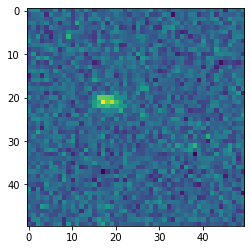

In [0]:
# simple plots of data

n = 0
print(labels[n])
plt.imshow(images[n][:,:,0], cmap='viridis')

In [0]:
# Subtract the mean, remove all negative values and scale following the max of each image
images_scaled = np.subtract(images, np.mean(images, axis=0))
images_scaled[images_scaled < 0] = 0.
images_scaled = np.divide(images_scaled, np.max(images_scaled, axis=0))

In [0]:
# split the dataset
x = images_scaled
y = to_categorical(labels)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

[0. 1. 0.]


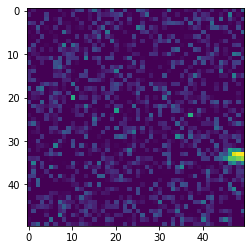

In [0]:
n = 6
print(y_train[n])
plt.imshow(x_train[n][:,:,0])

In [0]:
# building a model

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(50, 50, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

model.fit(
      x_train,
      y_train,  
      epochs=10,
      verbose=1)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 2400 samples
Epoch 1/10
2400/2400 [==============================] - 10s 4ms/sample - loss: 0.9915 - acc: 0.4967
Epoch 2/10
2400/2400 [==============================] - 10s 4ms/sample - loss: 0.2844 - acc: 0.9167
Epoch 3/10
2400/2400 [==============================] - 10s 4ms/sample - loss: 0.0612 - acc: 0.9812
Epoch 4/10
2400/2400 [==============================] - 10s 4ms/sample - loss: 0.0464 - acc: 0.9892
Epoch 5/10
2400/2400 [==============================] - 10s 4ms/sample - loss: 0.0400 - acc: 0.9904
Epoch 6/10
2400/2400 [==============================] - 10s 4ms/sample - loss: 0.0495 - acc: 0.9879
Epoch 7/10
2400/2400 [==============================] - 10s 4ms/sample - loss: 0.0290 - acc: 0.9933
Epoch 8/10
2400/2400 [==============================] - 10s 4ms/sample - loss: 0.0192 - acc: 0.9958
Epoch 9/10
2400/2400 [==============================] - 10s 4ms/sample - loss: 0.0196 - acc: 0.99

In [0]:
model.evaluate(x_test, y_test)

600/600 [==============================] - 1s 1ms/sample - loss: 0.0253 - acc: 0.9917


[0.025292747064183156, 0.9916667]

In [0]:
y_pred = model.predict(x_test)
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       189
           1       1.00      0.98      0.99       200
           2       0.99      0.99      0.99       211

    accuracy                           0.99       600
   macro avg       0.99      0.99      0.99       600
weighted avg       0.99      0.99      0.99       600



1


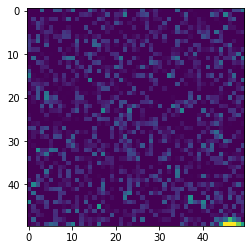

In [0]:
# a very simple single pixel attack

n = 1203 
print(np.argmax(y_train[n]))
plt.imshow(x_train[n][:,:,0])
copy = x_train[n]

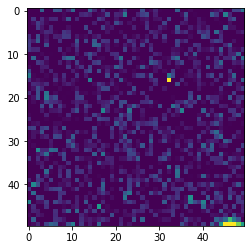

In [0]:
def perturb_image(xs, img):
  coord_x = xs[0]
  coord_y = xs[1]
  new_value = xs[2]
  img[coord_x, coord_y] = [new_value]
  return img
   
pixel = np.array([16, 32, 1])
image_perturbed = perturb_image(pixel, copy)
plt.imshow(image_perturbed[:,:,0])

In [0]:
from keras.preprocessing import image

x = image.img_to_array(image_perturbed)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict(images, batch_size=10)
print('new prediction is', np.argmax(classes),',', 'old prediction is', np.argmax(y_train[n]))

new prediction is 1 , old prediction is 1
